In [1]:
# the folder train eegs has a lot of parquet files. Read each of them and store the results in a dataframe
import pandas as pd
import pyarrow.parquet as pq
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import polars as pl
import dask
dask.config.set({'dataframe.query-planning': True})
import dask.dataframe as dd
from dask.distributed import Client
from tqdm import tqdm

tqdm.pandas()

In [2]:
train = pd.read_csv('data/train.csv')

In [3]:
len(train)

106800

In [4]:
# Check if the patient ids are the same for all unique eeg_ids
different_id_eeg_ids = train.groupby('eeg_id').progress_apply(lambda x: (x.loc[:, 'patient_id'].nunique() != 1))
different_id_eeg_ids = different_id_eeg_ids[different_id_eeg_ids].index.tolist()

  0%|          | 0/17089 [00:00<?, ?it/s]

100%|██████████| 17089/17089 [00:02<00:00, 8486.59it/s]


In [5]:
print(f'There are {len(different_id_eeg_ids)} eeg_ids with different patient_ids')
print(f'The eeg_ids are {different_id_eeg_ids}')


There are 0 eeg_ids with different patient_ids
The eeg_ids are []


In [6]:
# Check if the last 6 columns are the same for all unique eeg_ids
different_labels_eeg_ids = train.groupby('eeg_id').progress_apply(lambda x: (x.iloc[:, -6:].nunique() != 1).any())
different_labels_eeg_ids = different_labels_eeg_ids[different_labels_eeg_ids].index.tolist()

100%|██████████| 17089/17089 [00:10<00:00, 1650.92it/s]


In [7]:
print(f'There are {len(different_labels_eeg_ids)} eeg_ids with different labels in the last 6 columns')
print(f'These eeg_ids are: {different_labels_eeg_ids}')

There are 1807 eeg_ids with different labels in the last 6 columns
These eeg_ids are: [11127485, 19239792, 20299905, 21379701, 21746311, 24527714, 32067830, 35473474, 36718960, 36991694, 37347312, 39304625, 40537223, 42319244, 45189348, 46287152, 46540529, 51360893, 51565620, 56410582, 56878715, 57247159, 69489622, 71524527, 73267892, 79028197, 80214012, 81939314, 82324067, 83071260, 83891332, 85380311, 85702356, 86189315, 90225775, 92400159, 97579734, 98402506, 99659906, 102057647, 104136958, 111970389, 112582777, 114620689, 116807553, 119167896, 119858355, 120014791, 124190586, 130372011, 135276897, 138694022, 139575466, 140777105, 148395385, 148744122, 150916634, 154009868, 157675277, 159344495, 162439068, 163693460, 167662301, 171381836, 171821449, 173658325, 174997701, 180689244, 185181940, 186045431, 188361788, 192067839, 199316279, 201227016, 205424919, 207859016, 208900594, 210716027, 213707768, 214640515, 214743762, 215108398, 216551560, 218040948, 223097506, 224067544, 226568

In [8]:
train[train['eeg_id'].isin(different_labels_eeg_ids)].head(15)

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
54,2578018731,0,0.0,2207717,0,0.0,2581514982,34153,Other,0,0,0,0,0,1
55,2578018731,1,20.0,2207717,1,20.0,1928228287,34153,GRDA,0,0,2,0,9,2
56,2578018731,2,26.0,2207717,2,26.0,1227648793,34153,GRDA,0,0,2,0,9,2
57,2578018731,3,32.0,2207717,3,32.0,708727528,34153,GRDA,0,0,2,0,9,2
129,531742289,0,0.0,6075641,0,0.0,1456770042,51923,GPD,0,0,3,0,0,0
130,531742289,1,2.0,6075641,1,2.0,3516162114,51923,GPD,0,0,3,0,0,0
131,531742289,2,6.0,6075641,2,6.0,431522225,51923,GPD,0,0,3,0,0,0
132,531742289,3,14.0,6075641,3,14.0,760485346,51923,GPD,0,0,3,0,0,0
133,531742289,4,16.0,6075641,4,16.0,30093825,51923,GPD,0,0,3,0,0,0
134,531742289,5,18.0,6075641,5,18.0,1499797411,51923,GPD,0,0,3,0,0,0


In [9]:
train['eeg_id'].unique()

array([1628180742, 2277392603,  722738444, ..., 1850739625, 1306668185,
        351917269], dtype=int64)

In [10]:
# read the first eeg file
eeg = pq.read_table(f"data/train_eegs/{train['eeg_id'].unique()[0]}.parquet").to_pandas()
eeg.shape

(18000, 20)

In [28]:
eeg.head()

,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,-80.519997,-70.540001,-80.110001,-108.750000,-120.330002,-88.620003,-101.750000,-104.489998,-99.129997,-90.389999,-97.040001,-77.989998,-88.830002,-112.120003,-108.110001,-95.949997,-98.360001,-121.730003,-106.449997,7.920000
1,-80.449997,-70.330002,-81.760002,-107.669998,-120.769997,-90.820000,-104.260002,-99.730003,-99.070000,-92.290001,-96.019997,-84.500000,-84.989998,-115.610001,-103.860001,-97.470001,-89.290001,-115.500000,-102.059998,29.219999
2,-80.209999,-75.870003,-82.050003,-106.010002,-117.500000,-87.489998,-99.589996,-96.820000,-119.680000,-99.360001,-91.110001,-99.440002,-104.589996,-127.529999,-113.349998,-95.870003,-96.019997,-123.879997,-105.790001,45.740002
3,-84.709999,-75.339996,-87.480003,-108.970001,-121.410004,-94.750000,-105.370003,-100.279999,-113.839996,-102.059998,-95.040001,-99.230003,-101.220001,-125.769997,-111.889999,-97.459999,-97.180000,-128.940002,-109.889999,83.870003
4,-90.570000,-80.790001,-93.000000,-113.870003,-129.960007,-102.860001,-118.599998,-101.099998,-107.660004,-102.339996,-98.510002,-95.300003,-88.930000,-115.639999,-99.800003,-97.500000,-88.730003,-114.849998,-100.250000,97.769997


In [11]:
GET_ROW = 0
EEG_PATH = 'data/train_eegs/'
SPEC_PATH = 'data/train_spectrograms/'

train = pd.read_csv('data/train.csv')
row = train.iloc[GET_ROW]

eeg = pd.read_parquet(f'{EEG_PATH}{row.eeg_id}.parquet')
eeg_offset = int( row.eeg_label_offset_seconds )

spectrogram = pd.read_parquet(f'{SPEC_PATH}{row.spectrogram_id}.parquet')
spec_offset = int( row.spectrogram_label_offset_seconds )
spectrogram = spectrogram.loc[(spectrogram.time>=spec_offset)
                     &(spectrogram.time<spec_offset+600)]

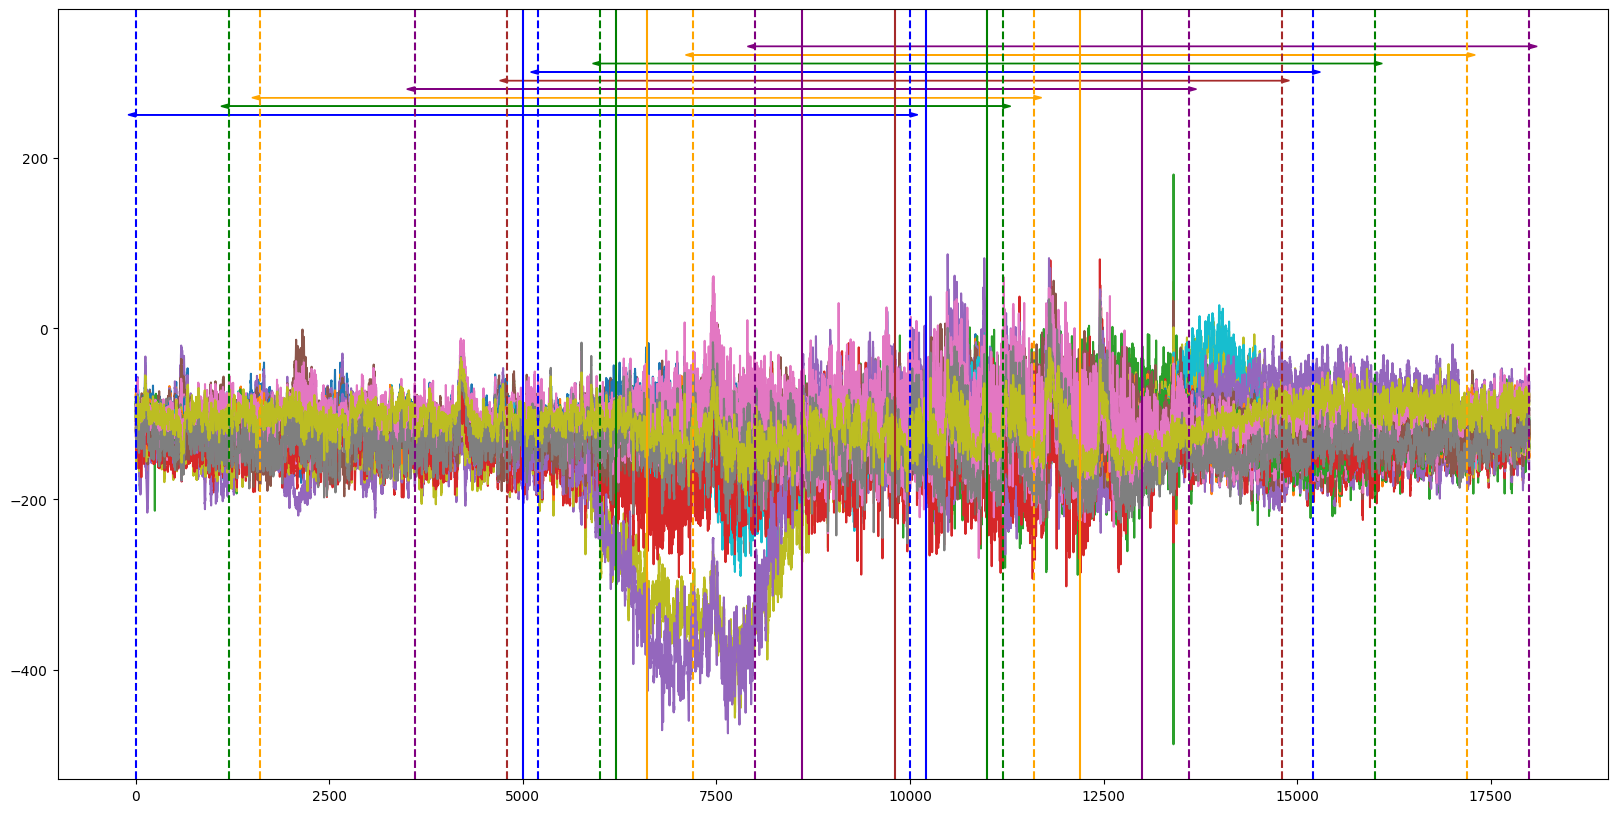

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'eeg' is your dataframe and 'eeg_labels' is your labels dataframe
# eeg = pd.read_csv('path_to_your_eeg_data.csv')
# eeg_labels = pd.read_csv('path_to_your_labels_data.csv')

plt.figure(figsize=(20, 10))
plt.plot(eeg.iloc[:, :-1])

# Define the initial vertical position for the arrows
arrow_height = 250  # start above the plot to avoid overlap
height_increment = 10  # increment to move the next arrow up

# Define a list of colors to cycle through
colors = ['blue', 'green', 'orange', 'purple', 'brown']

for idx, i in enumerate(train[train['eeg_id'] == train['eeg_id'].unique()[GET_ROW]]['eeg_label_offset_seconds']):
    color = colors[idx % len(colors)]  # Cycle through colors list
    
    left_x = i * 200
    right_x = i * 200 + 200 * 50
    center_x = i * 200 + 200 * 25
    
    # Draw vertical lines
    plt.axvline(x=left_x, color=color, linestyle='--')
    plt.axvline(x=right_x, color=color, linestyle='--')
    plt.axvline(x=center_x, color=color, linestyle='-')
    
    # Draw horizontal arrows
    plt.arrow(center_x, arrow_height, left_x - center_x, 0, head_width=5, head_length=100, fc=color, ec=color)
    plt.arrow(center_x, arrow_height, right_x - center_x, 0, head_width=5, head_length=100, fc=color, ec=color)
    
    # Increment the height for the next set of arrows to avoid overlap
    arrow_height += height_increment

plt.show()

In [30]:
# For each row in train, read the corresponding eeg file and extract the 50*200 samples from each eeg_label offset using groupby
# and apply
import pickle

def get_eegs(x, all_eegs, moving_max):
    eeg = pq.read_table(f"data/train_eegs/{x.eeg_id.iloc[0]}.parquet").to_pandas()
    all_eegs[x.eeg_id.iloc[0]] = eeg
    moving_max[0] = max(len(eeg), moving_max[0])



all_eegs = dict()
moving_max = np.array([0])
# read the spectrgormas per eeg id and extract all the 50*200 samples starting from each eeg label offset
# If the pickle file exists, load it, otherwise, create it
if os.path.exists('all_eegs.pkl'):
    all_eegs = pickle.load(open('all_eegs.pkl', 'rb'))
else:
    train.groupby('eeg_id').progress_apply(lambda x: get_eegs(x, all_eegs, moving_max))
print(moving_max)


[0]


In [14]:
# now dump the dict with pickle to avoid reading the eegs again
if not os.path.exists('all_eegs.pkl'):
    with open('all_eegs.pkl', 'wb') as f:
        pickle.dump(all_eegs, f)

In [15]:
def get_offsets(x, all_offsets):
    all_offsets[x.eeg_id.iloc[0]] = list(map(int, x.eeg_label_offset_seconds.reset_index(drop=True).tolist()))



all_offsets = dict()
# read the spectrgormas per eeg id and extract all the 50*200 samples starting from each eeg label offset
train.groupby('eeg_id').progress_apply(lambda x: get_offsets(x, all_offsets))
len(all_offsets)


100%|██████████| 17089/17089 [00:01<00:00, 8950.33it/s]


17089

In [16]:
all_offsets[11127485]

[0, 10, 26, 30, 32, 42, 44, 50, 58]

In [17]:
# for each key in all_eegs, extract the 50*200 samples starting from each eeg label offset
X = []

# Store the keys
keys = list(all_eegs.keys())
for k in tqdm(keys):
    for offset in all_offsets[k]:
        X.append(all_eegs[k].iloc[offset:offset+50*200, :-1].values)
X = np.array(X)
X.shape



100%|██████████| 17089/17089 [00:05<00:00, 2929.02it/s]


(106800, 10000, 19)

In [18]:
# Get the labels similarly to the offsets
def get_labels(x, all_labels):
    all_labels[x.eeg_id.iloc[0]] = x.iloc[:, -6:].reset_index(drop=True).values

all_labels = dict()
train.groupby('eeg_id').progress_apply(lambda x: get_labels(x, all_labels))
len(all_labels)

100%|██████████| 17089/17089 [00:02<00:00, 6668.58it/s]


17089

In [19]:
all_labels[11127485]

array([[3, 0, 0, 0, 0, 0],
       [4, 0, 1, 0, 0, 0],
       [3, 0, 0, 0, 0, 0],
       [3, 0, 0, 0, 0, 0],
       [3, 0, 0, 0, 0, 0],
       [3, 0, 0, 0, 0, 0],
       [3, 0, 0, 0, 0, 0],
       [3, 0, 0, 0, 0, 0],
       [3, 0, 0, 0, 0, 0]], dtype=int64)

In [22]:
# make an array from all the labels
y = []
for k in keys:
    y.append(all_labels[k])
y = np.vstack(y)
y.shape

(106800, 6)

In [23]:
# Cache X and y
np.save('X.npy', X)
np.save('y.npy', y)


In [26]:
import multi_res_bi_GRU
from torch import nn
from segmentation_models_pytorch import Unet
import torchaudio.transforms as T
from Unet_decoder import UNet1DDecoder
import torch


class MultiResidualBiGRUwSpectrogramCNN(nn.Module):
    def __init__(self, in_channels, out_channels, model_type, config, spec_features_indices):
        super(MultiResidualBiGRUwSpectrogramCNN, self).__init__()
        self.config = config
        self.gru_params = config.get('gru_params', {})
        self.spec_features_indices = spec_features_indices
        # TODO exclude some of the features from the spectrogram
        self.encoder = Unet(
            encoder_name=config.get('encoder_name', 'resnet34'),
            encoder_weights=config.get('encoder_weights', 'imagenet'),
            # The channels used by the encoder are for now only anglez and enmo
            # so this is hardcoded to 2 for now
            in_channels=len(spec_features_indices),
            classes=1,
            encoder_depth=config.get('encoder_depth', 5),
        )
        self.spectrogram = nn.Sequential(
            T.Spectrogram(n_fft=config.get('n_fft', 127), hop_length=config.get('hop_length', 1)),
            T.AmplitudeToDB(top_db=80),
            SpecNormalize()
        )
        self.GRU = multi_res_bi_GRU.MultiResidualBiGRU(input_size=in_channels,
                                                       hidden_size=self.gru_params.get("hidden_size", 64),
                                                       out_size=out_channels, n_layers=self.gru_params.get("n_layers", 5),
                                                       bidir=True, activation=self.gru_params.get("activation", "relu"),
                                                       flatten=False, dropout=0,
                                                       internal_layers=1, model_name='')
        # will shape the encoder outputs to the same shape as the original inputs
        self.liner = nn.Linear(in_features=(config.get('n_fft', 127)+1)//2, out_features=in_channels)

        self.decoder = UNet1DDecoder(
            n_channels=(config.get('n_fft', 127) + 1) // 2,
            n_classes=out_channels,
            bilinear=config.get('bilinear', False),
            scale_factor=config.get('scale_factor', 2),
            # hardcoded for now
            # TODO make this a config
            duration=17280 // (12*config.get('hop_length', 1)),
        )

    def forward(self, x, use_activation=True):
        # Pass only enmo and anglez to the spectrogram
        x = x.permute(0, 2, 1)
        x_spec = self.spectrogram(x[:, self.spec_features_indices, :])
        x_encoded = self.encoder(x_spec).squeeze(1)
        # The rest of the features are subsampled and passed to the decoder
        # as residual features
        if self.config.get('use_decoder', False):
            x_decoded = self.decoder(x_encoded)
        else:
            x_decoded = torch.zeros_like(x_encoded)
        x_encoded = x_encoded.permute(0, 2, 1)
        x_encoded_linear = self.liner(x_encoded)

        # TODO if some features are excluded from the spectrgoram chnage this
        # downsample the input features to the same shape as the encoded features
        x = x[:, self.spec_features_indices, ::self.config.get('hop_length')]
        # now sum the residual features x and the encoded features x
        x_encoded_linear[:, ::self.config.get('hop_length'), self.spec_features_indices] += x.permute(0, 2, 1)

        y, _ = self.GRU(x_encoded_linear, use_activation=use_activation)
        return y + x_decoded


class SpecNormalize(nn.Module):
    def __init__(self, eps: float = 1e-8):
        super().__init__()
        self.eps = eps

    def forward(self, x):
        # x: (batch, channel, freq, time)
        min_ = x.min(dim=-1, keepdim=True)[0].min(dim=-2, keepdim=True)[0]
        max_ = x.max(dim=-1, keepdim=True)[0].max(dim=-2, keepdim=True)[0]

        return (x - min_) / (max_ - min_ + self.eps)



c:\Users\Tolga\Desktop\EPOCH-IV\q3-HMS\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# make a train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


In [ ]:
# create a model
model = MultiResidualBiGRUwSpectrogramCNN(in_channels=19, out_channels=6, model_type='gru', config=dict())
